Setup

In [21]:
import numpy as np

from numba import jitclass, njit, int32, int64, float32
from tqdm import tqdm

Board

In [100]:
@jitclass([('position', int64),
           ('mask', int64),
           ('n_move', int32),
           ('top', int64)])
class Connect4Board(object):
  def __init__(self, position=0, mask=0, n_move=0, top=None):
    self.position = position
    self.mask = mask
    self.n_move = n_move

    if top is None:
      self.top = np.sum(1 << 6+7*np.arange(7))
    else:
      self.top = top
  
  def copy(self):
    return Connect4Board(self.position, self.mask, self.n_move, self.top)
  
  def reset(self):
    return Connect4Board(0, 0, 0, self.top)

  def _reset(self):
    self.position = 0
    self.mask = 0
    self.n_move = 0

    return self

  def is_valid_move(self, col):
    return (self.top & (self.mask + (1 << (col*7))) == 0)
  
  def available_moves(self):
    return [col for col in range(7) if self.is_valid_move(col)]
  
  def generate_moves(self):
    return [col for col in np.random.choice(7, size=7, replace=False) if self.is_valid_move(col)]

  def make_move(self, col):
    return Connect4Board(self.position ^ self.mask,
                         self.mask | (self.mask + (1 << (col*7))),
                         self.n_move + 1,
                         self.top)

  def _make_move(self, col):
    self.position = self.position ^ self.mask
    self.mask = self.mask | (self.mask + (1 << (col*7)))
    self.n_move += 1
    return self
  
  def is_win(self):
    opposition = self.position ^ self.mask
    # Horizontal check
    m = opposition & (opposition >> 7)
    if m & (m >> 14):
        return True
    # Diagonal \
    m = opposition & (opposition >> 6)
    if m & (m >> 12):
        return True
    # Diagonal /
    m = opposition & (opposition >> 8)
    if m & (m >> 16):
        return True
    # Vertical
    m = opposition & (opposition >> 1)
    if m & (m >> 2):
        return True
    # Nothing found
    return False
  
  def is_draw(self):
    return self.n_move == 42
  
  def is_terminal(self):
    return self.is_win() or self.is_draw()
  
  def to_array(self):
    board = np.zeros((6,7), dtype=np.int32)

    opponent = self.position ^ self.mask
    p0, p1 = ((opponent, self.position) if self.n_move % 2 else 
              (self.position, opponent))
    
    for j in range(7):
      m = np.int64(1) << j*7
      for i in range(6):
        if p0 & m:
          board[i,j] = 1
        elif p1 & m:
          board[i,j] = -1
        else:
          break
        m <<= 1
    
    return board
  
  def to_string(self):
    a = self.to_array()
    c = {0:'-', 1:'O', -1:'X'}
    s = ''
    for i in range(a.shape[0]-1, -1, -1):
      for j in range(a.shape[1]):
        s += c[a[i,j]] + ' '
      s += '\n'
    
    return s
  
  def hash(self):
    return hash((self.position, self.mask))

Evaluator

In [23]:
@njit
def bitwise_or_reduce(xs):
  s = 0
  for x in xs:
    s |= x

  return s

@jitclass([('i_bottom', int32[:]),
           ('bottom', int64),
           ('cols', int64[:]),
           ('d', int32[:]),
           ('weights', float32[:,::1])])
class Connect4Evaluator(object):
  def __init__(self):
    self.i_bottom = np.int32(7) * np.arange(7, dtype=np.int32)
    self.bottom = np.sum(1 << self.i_bottom)
    self.cols = ((np.int64(1) << 7) - 1) << self.i_bottom
    self.d = np.array([7,6,8,1], dtype=np.int32)
    self.weights = np.array([[0.001,0.009,0.09,0.9],
                             [0.001,0.009,0.09,0.4]], dtype=np.float32)

  def evaluate(self, board: Connect4Board, color=1):
    # if last player won then current player lost
    if board.is_win():
      return (board.n_move + 1) // 2 - 22.0
    # game drawn
    elif board.is_draw():
      return 0.0
    # intermediate state
    else:
      mask = board.mask | board.top
      cur_n = self._evaluate(board.position, mask)
      opp_n = self._evaluate(board.position ^ board.mask, mask)
      max_score = 21.0 - board.n_move // 2
      cur_value = np.dot(cur_n, self.weights[0])
      if cur_value >= 1.0:
        return 21.0 - board.n_move // 2
      opp_value = np.dot(opp_n, self.weights[1])
      if opp_value >= 1.0:
        return (board.n_move+1) // 2 - 21.0
      return (21.0 - (board.n_move+2) // 2) * (cur_value - opp_value)
  
  def _evaluate(self, pos, mask):
    n_mask = ~mask
    nxt = mask + self.bottom

    # lij : at least i consecutive elements starting withing j places on left
    l11 = pos >> self.d
    l12 = l11 | (l11 & n_mask) >> self.d
    l13 = l12 | (l12 & n_mask) >> self.d

    l21 = l11 & (l11 >> self.d)
    l22 = l21 | (l21 & n_mask) >> self.d

    l31 = l21 & (l21 >> self.d)

    # rij : at least i consecutive elements starting withing j places on right
    r11 = pos << self.d
    r12 = r11 | (r11 & n_mask) << self.d
    r13 = r12 | (r12 & n_mask) << self.d

    r21 = r11 & (r11 << self.d)
    r22 = r21 | (r21 & n_mask) << self.d

    r31 = r21 & (r21 << self.d)

    # ci : at least i elements within a 4 element frame that contains it
    c1 = bitwise_or_reduce((l13 | r13) & n_mask)
    c2 = bitwise_or_reduce((l22 | r22 | (l11 & r12) | (l12 & r11)) & n_mask)
    c3 = bitwise_or_reduce((l31 | r31 | (l21 & r11) | (l11 & r21)) & n_mask)
    # c3t : adding one more here will make it win
    c3t = c3 & nxt

    c = np.array([[c1],[c2],[c3],[c3t]])

    n = np.sum((c & self.cols) != 0, axis=1, dtype=np.float32)

    return n

Negamax

In [24]:
class TranspositionTableEntry(object):
  def __init__(self, value, flag, depth):
    self.value = value
    self.flag = flag
    self.depth = depth

class NegamaxSearcher(object):
  EXACT = 0
  LOWERBOUND = -1
  UPPERBOUND = 1
  def __init__(self, evaluator, depth):
    self.evaluate = np.vectorize(evaluator.evaluate)
    self.depth = depth
  
  def __call__(self, node) -> int:
    # initialize tranposition table
    self.t_table = {}

    moves = np.array(node.generate_moves())
    if self.depth <= 0:
      return moves[0]
    children = np.array([node.make_move(move) for move in moves])

    values = self.evaluate(children, -1)
    if self.depth == 1:
      index = np.argmax(-values)
      return moves[index]

    order = values.argsort()

    value = (-np.inf, None)
    a, b = -np.inf, np.inf
    for move,child in zip(moves[order],children[order]):
      value = max(value, (-self.__negamax(child, self.depth-1, -b, -a, -1), move), key=lambda x: x[0])
      a = max(a, value[0])
      if a >= b:
        break
    
    return value[1]

  def __negamax(self, node, depth, a, b, color) -> float:
    a_orig = a
    
    # Transposition Table Lookup; node is the lookup key for t_entry
    t_entry = self.t_table.get(node.hash())
    if t_entry is not None and t_entry.depth >= depth:
      if t_entry.flag == self.EXACT:
        return t_entry.value
      elif t_entry.flag == self.LOWERBOUND:
        a = max(a, t_entry.value)
      elif t_entry.flag == self.UPPERBOUND:
        b = min(b, t_entry.value)
      
      if a >= b:
        return t_entry.value

    
    if depth < 1 or node.is_terminal():
      return self.evaluate(node, color)
    
    moves = node.generate_moves()
    children = np.array([node.make_move(move) for move in moves])

    values = self.evaluate(children, -color)
    if depth == 1:
      return np.max(-values)

    order = values.argsort()

    value = -np.inf
    for child in children[order]:
      value = max(value, -self.__negamax(child, depth-1, -b, -a, -color))
      a = max(a, value)
      if a >= b:
        break
    
    # Transposition Table Store; node is the lookup key for t_entry
    if value <= a_orig:
      flag = self.UPPERBOUND
    elif value >= b:
      flag = self.LOWERBOUND
    else:
      flag = self.EXACT
    
    t_entry = TranspositionTableEntry(value, flag, depth)
    self.t_table[node.hash()] = t_entry
    
    return value

MCTS

In [87]:
from numba import njit, jitclass, types, int32, float32, deferred_type, optional
import numpy as np 

node_type = deferred_type()

@jitclass([('parent', optional(node_type)),
           ('next', optional(node_type)),
           ('child', optional(node_type)),
           ('player_id', int32),
           ('action', int32),
           ('visits', int32),
           ('score', int32)])
class Node:
  def __init__(self, player_id, action=-1):
      self.player_id = player_id
      self.action = action
      self.visits = 0
      self.score = 0
      self.parent = None
      self.next = None
      self.child = None
  
  def is_leaf(self):
    return (self.child is None)

  def add_child(self, node):
    node.parent = self
    node.next = self.child
    self.child = node
    return self
  
  def add_children(self, player_id, actions):
    for action in actions:
      self.add_child(Node(player_id, action))
    
    return self
  
  def get_child_with_max_visits(self):
    max_child = None
    max_visits = -np.inf
    
    child = self.child
    while child is not None:
      if child.visits > max_visits:
        max_visits = child.visits
        max_child = child
      
      child = child.next
    
    return max_child
  
  def get_child_with_max_ucb(self):
    max_ucb = -np.inf
    max_children = []
    
    child = self.child
    while child is not None:
      child_ucb = child.ucb()
      if child_ucb > max_ucb:
        max_children.clear()
        max_children.append(child)
        max_ucb = child_ucb

      elif child_ucb == max_ucb:
        max_children.append(child)
        
      child = child.next

    n = len(max_children)

    return max_children[np.random.choice(n)]
  
  def get_children(self):
    children = []

    child = self.child
    while child is not None:
      children.append(child)
      child = child.next
    
    return children
  
  def ucb(self):
    if self.visits == 0:
      return np.inf
    return self.score / self.visits + 2 * (np.log(self.parent.visits) / self.visits) ** 0.5


node_type.define(Node.class_type.instance_type)

In [89]:
class MctsSearcher(object):
  def __init__(self, rollout_limit):
    self.rollout_limit = rollout_limit

  def __call__(self, game):
    root = Node(1)

    for _ in range(self.rollout_limit):
      self.__simulate_game(game.copy(), root, player_id=1)
    
    return root.get_child_with_max_visits().action

  @staticmethod
  @njit
  def __simulate_game(game, current_node, player_id):
    nodes_to_update = [current_node]
    last_id = player_id

    # walk to leaf node
    while not current_node.is_leaf():
      current_node = current_node.get_child_with_max_ucb()
      col = current_node.action
      game._make_move(col)
      last_id *= -1
      nodes_to_update.append(current_node)

    if not game.is_terminal():
      # create new child nodes from leaf
      current_node.add_children(last_id, game.generate_moves())

      best_new_child_node = current_node.get_child_with_max_ucb()
      game._make_move(best_new_child_node.action)
      last_id *= -1

      # play rest of game randomly
      while not game.is_terminal():
        random_move = game.generate_moves()[0]
        game._make_move(random_move)
        last_id *= -1
      
    if game.is_win():
      score = 1 if last_id != player_id else -1
    else:
      score = 0
      
    for node_to_update in nodes_to_update:
      node_score = score if node_to_update.player_id == player_id else -score
      node_to_update.visits += 1
      node_to_update.score += node_score

Run Game

In [108]:
board = Connect4Board()
negamax = NegamaxSearcher(Connect4Evaluator(), 4)
mcts = MctsSearcher(1000)

def human(board):
  return int(input())

names = ('human','negamax','mcts')
players = (human, negamax, mcts)

def run(board, players, names):
  print(board.to_string())
  turn = 0
  step = 1
  while not board.is_terminal():
    col = players[turn](board)
    board = board.make_move(col)
    print('step {0}: player {1}-{2}\nmove: {3}'.format(step, 1+turn, names[turn], col))
    print(board.to_string())
    turn = 1 - turn
    step += 1
  if board.is_win():
    print('player {0}-{1} won'.format(2-turn, names[1-turn]))
  else:
    print('drawn')

In [111]:
s = """Select player {0}
0: Human
1: Negamax
2: MCTS"""
print(s.format(1))
p1 = int(input())
print(s.format(2))
p2 = int(input())

run(board, [players[p1], players[p2]], [names[p1], names[p2]])

Select player 1
0: Human
1: Negamax
2: MCTS
2
Select player 2
0: Human
1: Negamax
2: MCTS
2
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 

step 1: player 1-mcts
move: 1
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- O - - - - - 

step 2: player 2-mcts
move: 3
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- O - X - - - 

step 3: player 1-mcts
move: 4
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- O - X O - - 

step 4: player 2-mcts
move: 4
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - X - - 
- O - X O - - 

step 5: player 1-mcts
move: 3
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - O X - - 
- O - X O - - 

step 6: player 2-mcts
move: 1
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- X - O X - - 
- O - X O - - 

step 7: player 1-mcts
move: 4
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - O - - 
-

Simulation

In [91]:
def simulate(board, players, num_simulation):
  n_win, n_draw, n_lose = 0, 0, 0
  for _ in tqdm(range(num_simulation)):
    turn = 0
    board._reset()
    while not board.is_terminal():
      col = players[turn](board)
      board._make_move(col)
      turn = 1 - turn
    
    if board.is_win():
      if turn != 0:
        n_win += 1
      else:
        n_lose += 1
    else:
      n_draw += 1
  
  return n_win, n_draw, n_lose

In [92]:
num_simulation = 100
mcts_rollout = 1000
negamax_depth = 4

mcts = MctsSearcher(mcts_rollout)
negamax = NegamaxSearcher(Connect4Evaluator(), negamax_depth)

board = Connect4Board()
p1_win, p1_draw, p1_lose = simulate(board, [mcts, negamax], num_simulation)
p2_lose, p2_draw, p2_win = simulate(board, [negamax, mcts], num_simulation)

100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


Plot

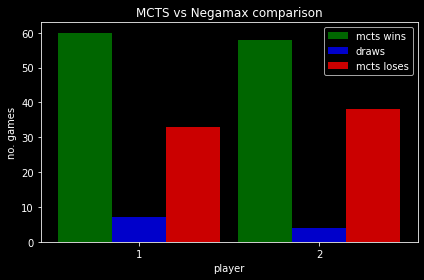

In [93]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
# data to plot
n_groups = 2
wins = (p1_win, p2_win)
loses = (p1_lose, p2_lose)
draws = (p1_draw, p2_draw)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, wins, bar_width,
alpha=opacity,
color='g',
label='mcts wins')

rects2 = plt.bar(index + bar_width, draws, bar_width,
alpha=opacity,
color='b',
label='draws')

rects2 = plt.bar(index + 2*bar_width, loses, bar_width,
alpha=opacity,
color='r',
label='mcts loses')

plt.xlabel('player')
plt.ylabel('no. games')
plt.title('MCTS vs Negamax comparison')
plt.xticks(index + bar_width, ('1', '2'))
plt.legend()

plt.tight_layout()
plt.show()